In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
import astropy.stats as st


from matplotlib import rcParams
# rcParams["font.size"] = 14
# rcParams["text.usetex"] = True
# rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function

In [2]:
inFile = 'corrected_mags_linewidth_all.csv'

table   = np.genfromtxt(inFile , delimiter='|', filling_values=-99999, names=True, dtype=None, encoding=None)

Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

u0 = table['u']
g0 = table['g']
r0 = table['r']
i0 = table['i']
z0 = table['z']
w10 = table['w1']
w20 = table['w2']

u_s = table['u_s']
g_s = table['g_s']
r_s = table['r_s']
i_s = table['i_s']
z_s = table['z_s']
w1_s = table['w1_s']
w2_s = table['w2_s']

u_ss = table['u_ss']
g_ss = table['g_ss']
r_ss = table['r_ss']
i_ss = table['i_ss']
z_ss = table['z_ss']
w2_ss = table['w2_ss']

u_sss = table['u_sss']
g_sss = table['g_sss']
r_sss = table['r_sss']
i_sss = table['i_sss']
z_sss = table['z_sss']
w1_sss = table['w1_sss']
w2_sss = table['w2_sss']

R_source = table['R_source']

gamma_u = table['gamma_u']
gamma_g = table['gamma_g']
gamma_r = table['gamma_r']
gamma_i = table['gamma_i']
gamma_z = table['gamma_z']
gamma_w1 = table['gamma_w1']
gamma_w2 = table['gamma_w2']

gamma_p_u = table['gamma_p_u']
gamma_p_g = table['gamma_p_g']
gamma_p_r = table['gamma_p_r']
gamma_p_i = table['gamma_p_i']
gamma_p_z = table['gamma_p_z']
gamma_p_w1 = table['gamma_p_w1']
gamma_p_w2 = table['gamma_p_w2']

logWimx = table['logWimx']

N = len(Sqlt)
q = np.zeros(N)

q[np.where(Sqlt>2)]+=1
q[np.where(Wqlt>2)]+=1
indx, = np.where(q==2)

In [37]:
print len(Sqlt)

print len(np.where(R_source==0)[0])
print len(np.where(R_source==1)[0])
print len(np.where(R_source==2)[0])

print len(np.where((Sqlt>0) & (Wqlt>0))[0])

10736
5395
355
4986
2244


### Genrating comparison plots for quality data

All galaxies in this subsample have both SDSS and WISE photometry with user reported quality of at elast 2, i.e. Wsql>1 and Sqlt>1.



In [3]:
print len(indx) # get the number of galaxies used in the following plots

2176


In [4]:
def rmsMaker(X):
    

    Y_fit2 = X
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N-1))
    
    
 
    return rms

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


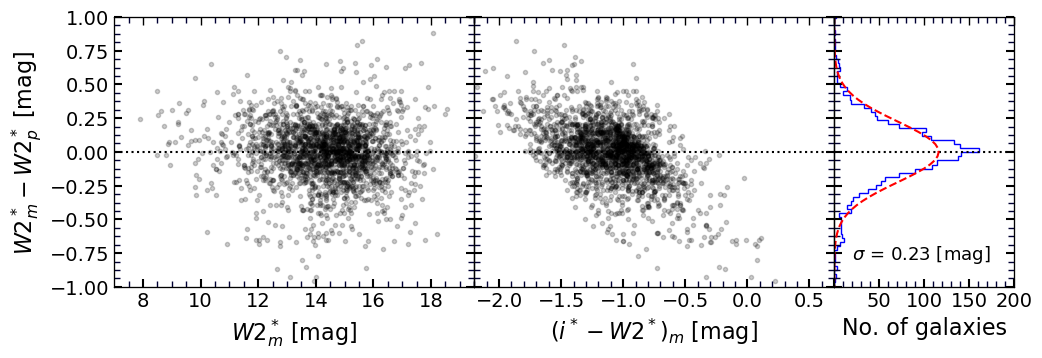

In [5]:
W2_lst  = w2_s[indx]
w2p_lst = w2_ss[indx]
i_w2    = i_s[indx]-w2_s[indx]


#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,19.5], [-1,1])
ax.set_xlabel(r'$W2^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)

ax_.plot(i_w2, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax_.plot([-20,20],[0,0], 'k:')
set_axes([ax_], [-2.2,0.7], [-1,1])
ax_.set_xlabel(r'$(i^*-W2^*)_m$'+' [mag]', fontsize=16)
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
# ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
ax__.text(20,-0.8, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=100, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,200], [-1,1])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)

Text(0,0.5,'$W2^*_m-W2^*_p$ [mag]')

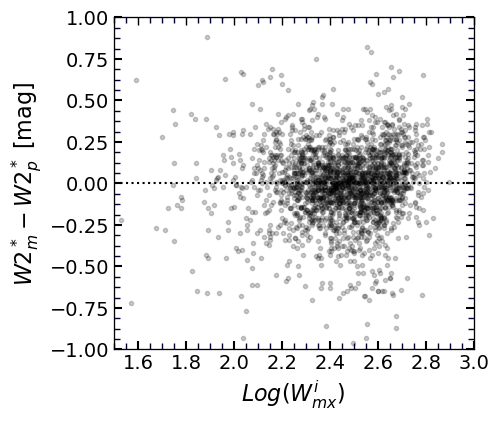

In [6]:
fig = py.figure(figsize=(4.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(logWimx[indx], W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [1.5,3], [-1,1])
ax.set_xlabel(r'$Log( W_{mx}^i)$'+' ', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)



In [7]:
print rmsMaker(W2_lst-w2p_lst)
print st.biweight_location(W2_lst-w2p_lst), np.sqrt(st.biweight_midvariance(W2_lst-w2p_lst))

0.20086291386287472
0.005082408845530782 0.21051128189412313


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


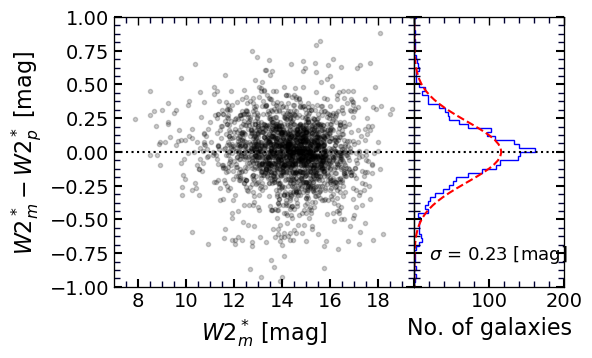

In [8]:
W2_lst  = w2_s[indx]
w2p_lst = w2_ss[indx]
i_w2    = i_s[indx]-w2_s[indx]


#################################################################
fig = py.figure(figsize=(6, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2, width_ratios=[1,0.5]) 

ax = plt.subplot(gs[0])
# ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[1])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,19.5], [-1,1])
ax.set_xlabel(r'$W2^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$W2^*_m-W2^*_p$'+' [mag]', fontsize=16)

# ax_.plot(i_w2, W2_lst-w2p_lst, '.', color='orange', alpha=0.2)
# ax_.plot([-20,20],[0,0], 'k:')
# set_axes([ax_], [-2.2,0.7], [-1,1])
# ax_.set_xlabel(r'$(i^*-W2^*)_m$'+' [mag]', fontsize=16)
# plt.setp(ax_.get_yticklabels(), visible=False)
# plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
# ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
ax__.text(20,-0.8, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=100, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,200], [-1,1])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''), Text(0,0,'500'), Text(0,0,'1000'), Text(0,0,'1500')]

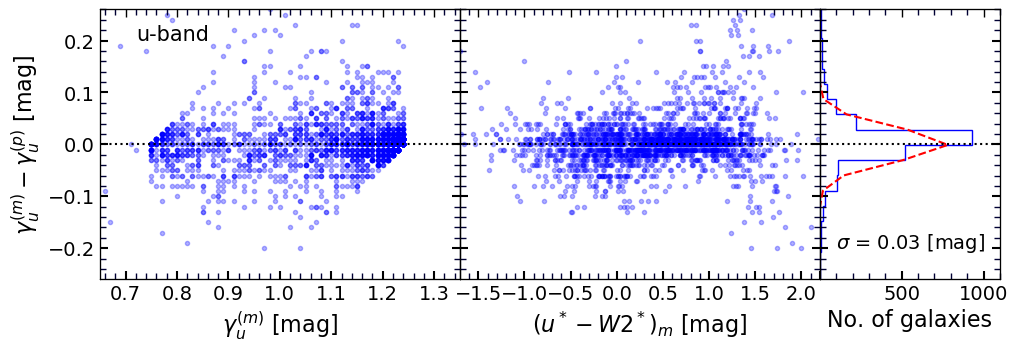

In [9]:
gamma_m = gamma_u[indx]
gamma_p = gamma_p_u[indx]
u_w2    = u_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='blue', alpha=0.3)
ax_.plot(u_w2, gamma_m-gamma_p, '.', color='blue', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.1)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,1100], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_u^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(u^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_u^{(m)}-\gamma_u^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.72,0.20, 'u-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1100],[0,0], 'k:')
set_axes([ax], [0.65,1.35], [-0.26,0.26])
set_axes([ax_], [-1.7,2.2], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


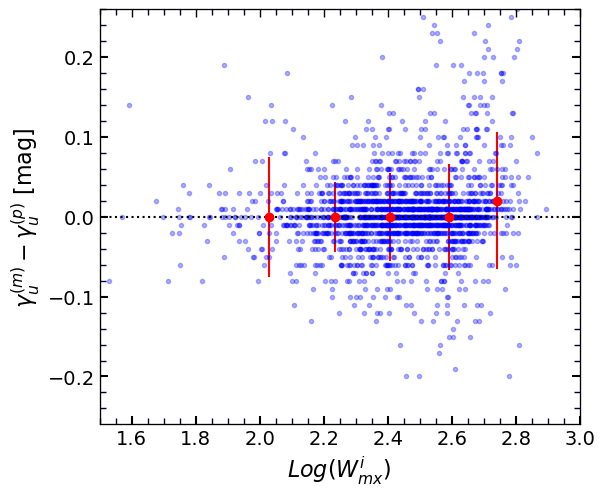

In [10]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(logWimx[indx], gamma_m-gamma_p, '.', color='b', alpha=0.3)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [1.5,3], [-0.26,0.26])
ax.set_xlabel(r'$Log( W_{mx}^i)$'+' ', fontsize=16)
ax.set_ylabel(r'$\gamma_u^{(m)}-\gamma_u^{(p)}$'+' [mag]', fontsize=16)


y = gamma_m-gamma_p
x = logWimx[indx]

for x0 in np.arange(1.9,3.0,0.2):
    ind, = np.where(x>=x0)
    x_ = x[ind]
    y_ = y[ind]
    ind, = np.where(x_<x0+0.2)
    x_ = x_[ind]
    y_ = y_[ind]    
    
    ax.errorbar(np.median(x_), np.median(y_), yerr=np.std(y_), fmt='o', color='red')
    


In [11]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.03297735811960901
0.0008203336776148422 0.03420589888865626


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

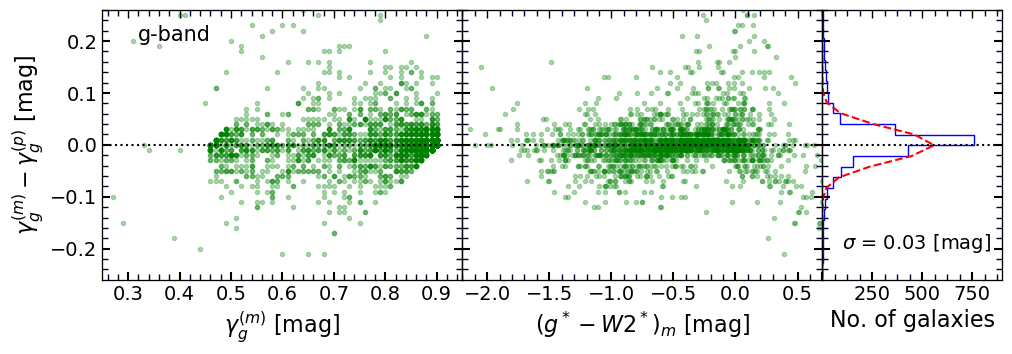

In [12]:
gamma_m = gamma_g[indx]
gamma_p = gamma_p_g[indx]
g_w2    = g_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='green', alpha=0.3)
ax_.plot(g_w2, gamma_m-gamma_p, '.', color='green', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.1)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_g^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(g^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_g^{(m)}-\gamma_g^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.32,0.20, 'g-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [0.25,0.95], [-0.26,0.26])
set_axes([ax_], [-2.2,0.7], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

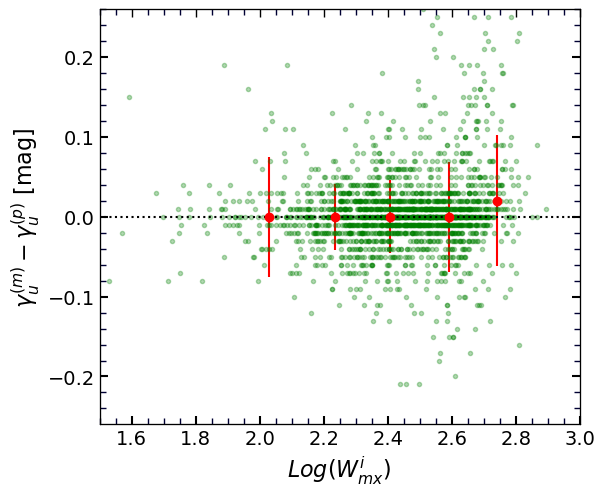

In [13]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(logWimx[indx], gamma_m-gamma_p, '.', color='g', alpha=0.3)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [1.5,3], [-0.26,0.26])
ax.set_xlabel(r'$Log( W_{mx}^i)$'+' ', fontsize=16)
ax.set_ylabel(r'$\gamma_u^{(m)}-\gamma_u^{(p)}$'+' [mag]', fontsize=16)


y = gamma_m-gamma_p
x = logWimx[indx]

for x0 in np.arange(1.9,3.0,0.2):
    ind, = np.where(x>=x0)
    x_ = x[ind]
    y_ = y[ind]
    ind, = np.where(x_<x0+0.2)
    x_ = x_[ind]
    y_ = y_[ind]    
    
    ax.errorbar(np.median(x_), np.median(y_), yerr=np.std(y_), fmt='o', color='red')
    


In [14]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.03237755909333524
0.0007013447370811286 0.0333614011644978


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

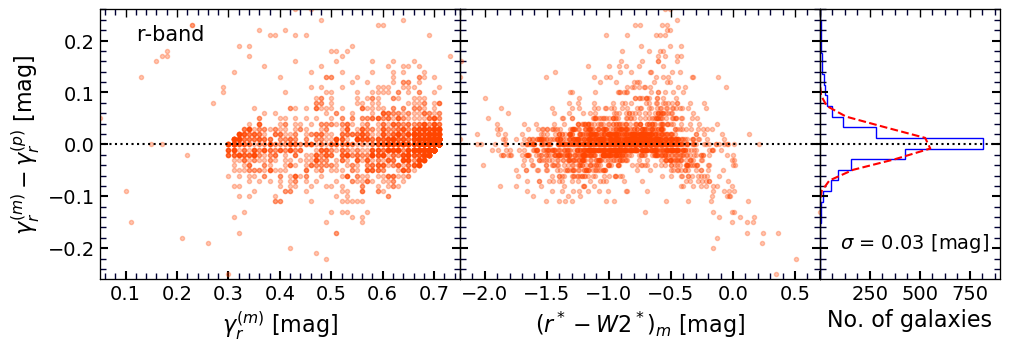

In [15]:
gamma_m = gamma_r[indx]
gamma_p = gamma_p_r[indx]
r_w2    = r_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='orangered', alpha=0.3)
ax_.plot(r_w2, gamma_m-gamma_p, '.', color='orangered', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.1)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=40, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_r^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(r^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_r^{(m)}-\gamma_r^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.12,0.20, 'r-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [0.05,0.75], [-0.26,0.26])
set_axes([ax_], [-2.2,0.7], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

In [16]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.02982560861296644
0.0004930896449733394 0.03159992670053838


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

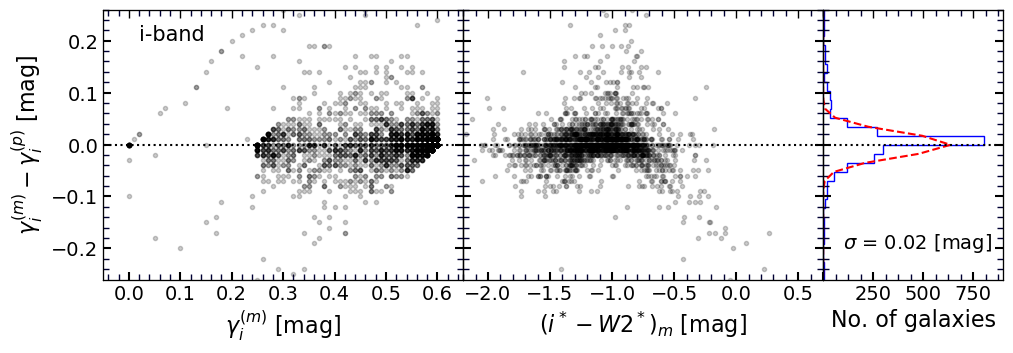

In [17]:
gamma_m = gamma_i[indx]
gamma_p = gamma_p_i[indx]
i_w2    = i_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='k', alpha=0.2)
ax_.plot(i_w2, gamma_m-gamma_p, '.', color='k', alpha=0.2)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.07)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_i^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(i^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=16)

ax.text(0.02,0.20, 'i-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [-0.05,0.65], [-0.26,0.26])
set_axes([ax_], [-2.2,0.7], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

In [18]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.02973805774154742
0.0001836953516792717 0.025301228612647175


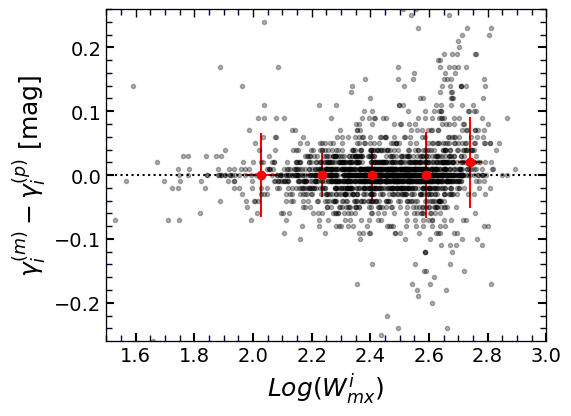

In [19]:
fig = py.figure(figsize=(5.5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

#################################################################

ax.plot(logWimx[indx], gamma_m-gamma_p, '.', color='k', alpha=0.3)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [1.5,3], [-0.26,0.26])
ax.set_xlabel(r'$Log( W_{mx}^i)$'+' ', fontsize=18)
ax.set_ylabel(r'$\gamma_i^{(m)}-\gamma_i^{(p)}$'+' [mag]', fontsize=18)


y = gamma_m-gamma_p
x = logWimx[indx]

for x0 in np.arange(1.9,3.0,0.2):
    ind, = np.where(x>=x0)
    x_ = x[ind]
    y_ = y[ind]
    ind, = np.where(x_<x0+0.2)
    x_ = x_[ind]
    y_ = y_[ind]    
    
    ax.errorbar(np.median(x_), np.median(y_), yerr=np.std(y_), xerr=np.std(x_), fmt='o', color='red')
    


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''),
 Text(0,0,'250'),
 Text(0,0,'500'),
 Text(0,0,'750'),
 Text(0,0,'1000')]

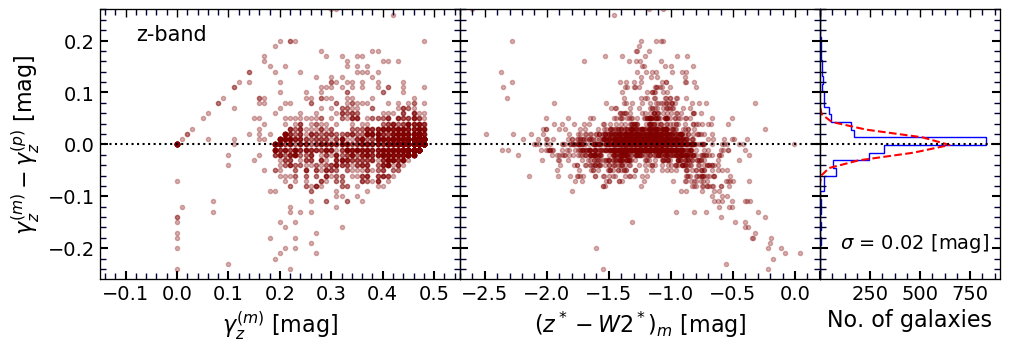

In [20]:
gamma_m = gamma_z[indx]
gamma_p = gamma_p_z[indx]
z_w2    = z_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='maroon', alpha=0.3)
ax_.plot(z_w2, gamma_m-gamma_p, '.', color='maroon', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.05)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(100,-0.2, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,900], [-0.26,0.26])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_z^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(z^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_z^{(m)}-\gamma_z^{(p)}$'+' [mag]', fontsize=16)

ax.text(-0.08,0.20, 'z-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,1000],[0,0], 'k:')
set_axes([ax], [-0.15,0.55], [-0.26,0.26])
set_axes([ax_], [-2.7,0.2], [-0.26,0.26])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

In [21]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.026995836883687525
0.00014663335020624946 0.02395021719608973


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


[Text(0,0,''), Text(0,0,'500'), Text(0,0,'1000'), Text(0,0,'1500')]

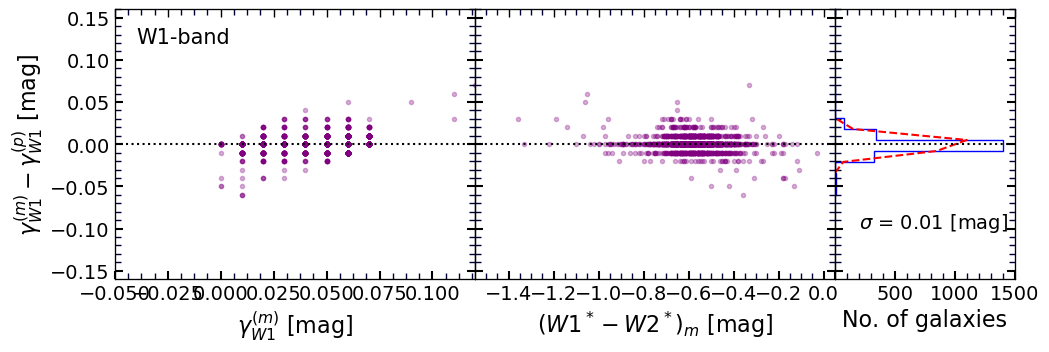

In [22]:
gamma_m = gamma_w1[indx]
gamma_p = gamma_p_w1[indx]
w1_w2    = w1_s[indx]-w2_s[indx]

#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################


ax.plot(gamma_m, gamma_m-gamma_p, '.', color='purple', alpha=0.3)
ax_.plot(w1_w2, gamma_m-gamma_p, '.', color='purple', alpha=0.3)

XX = gamma_m-gamma_p
XX = XX[np.where(np.abs(XX)<0.07)]
mu =  np.median(XX)
sigma = np.std(XX)
#################################################################
ax__.text(200,-0.1, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
#################################################################

n, bins, patches = ax__.hist(gamma_m-gamma_p, bins=10, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,1500], [-0.16,0.16])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab

y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

ax.set_xlabel(r'$\gamma_{W1}^{(m)}$'+' [mag]', fontsize=16)
ax_.set_xlabel(r'$(W1^*-W2^*)_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$\gamma_{W1}^{(m)}-\gamma_{W1}^{(p)}$'+' [mag]', fontsize=16)

ax.text(-0.04,0.12, 'W1-band', fontsize=15, color='k')
ax.plot([-1,10],[0,0], 'k:')
ax_.plot([-100,100],[0,0], 'k:')
ax__.plot([0,2000],[0,0], 'k:')
set_axes([ax], [-0.05,0.12], [-0.16,0.16])
set_axes([ax_], [-1.55,0.05], [-0.16,0.16])
plt.setp(ax_.get_yticklabels(), visible=False)
plt.setp(ax__.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

In [23]:
print rmsMaker(gamma_m-gamma_p)
print st.biweight_location(gamma_m-gamma_p), np.sqrt(st.biweight_midvariance(gamma_m-gamma_p))

0.006901786755728235
0.0 0.0


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


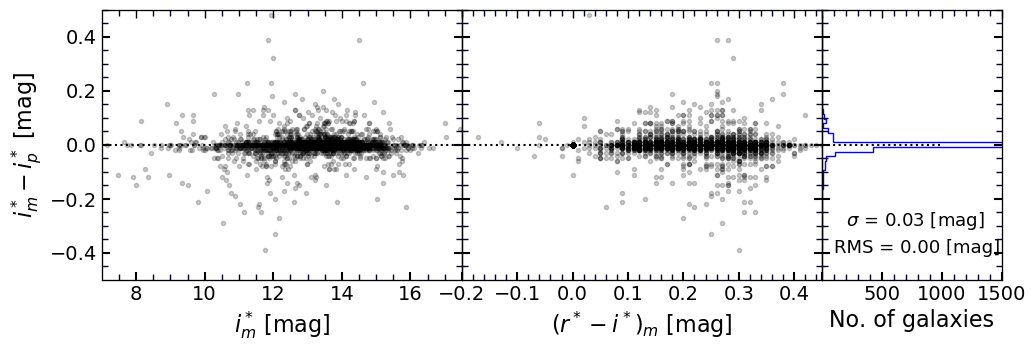

In [24]:
indx, = np.where(R_source==2)    # W2 is used for reddening correction

W2_lst  = i_s[indx]
w2p_lst = i_ss[indx]
i_w2    = r_s[indx]-i_s[indx]


#################################################################
fig = py.figure(figsize=(12, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,0.5]) 

ax = plt.subplot(gs[0])
ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[2])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,17.5], [-0.5,0.5])
ax.set_xlabel(r'$i^*_m$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$i^*_m-i^*_p$'+' [mag]', fontsize=16)

ax_.plot(i_w2, W2_lst-w2p_lst, '.', color='black', alpha=0.2)
ax_.plot([-20,20],[0,0], 'k:')
set_axes([ax_], [-0.2,0.45], [-0.5,0.5])
ax_.set_xlabel(r'$(r^*-i^*)_m$'+' [mag]', fontsize=16)
plt.setp(ax_.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=.0, wspace=0)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = 0 # np.median(XX)
sigma = np.std(XX)
#################################################################
rms = np.sqrt(np.median(XX**2))
ax__.text(100,-0.4, 'RMS = '+'%.2f'%rms+' [mag]', fontsize=13, color='k')
ax__.text(200,-0.3, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=50, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,1500], [-0.5,0.5])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
# ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)

In [25]:
print rmsMaker(W2_lst-w2p_lst)
print st.biweight_location(W2_lst-w2p_lst), np.sqrt(st.biweight_midvariance(W2_lst-w2p_lst))

0.005621387729022095
0.0 0.0


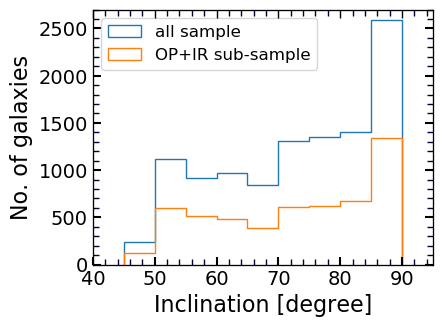

In [26]:
indx, = np.where(np.logical_or(R_source==2,R_source==1))    # W2 is used for reddening correction
sub_inc = table['inc'][indx]
inc = table['inc']


fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
                  
ax.hist(inc, bins=9, histtype='step', label='all sample')
ax.hist(sub_inc, bins=9, histtype='step', label='OP+IR sub-sample')

ax.legend(prop={'size': 12}, loc=2)

ax.set_xlabel('Inclination [degree]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)


set_axes([ax], [40,95], [0,2700])

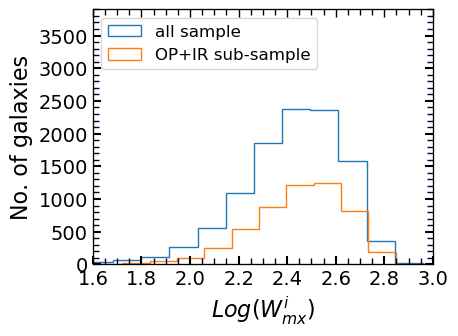

In [27]:
indx, = np.where(np.logical_or(R_source==2,R_source==1))    # W2 is used for reddening correction
i0_sub = table['logWimx'][indx]


fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
                  
ax.hist(table['logWimx'], bins=15, histtype='step', label='all sample')
ax.hist(i0_sub, bins=15, histtype='step', label='OP+IR sub-sample')

ax.legend(prop={'size': 12}, loc=2)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)


set_axes([ax], [1.6,3.0], [0,3900])

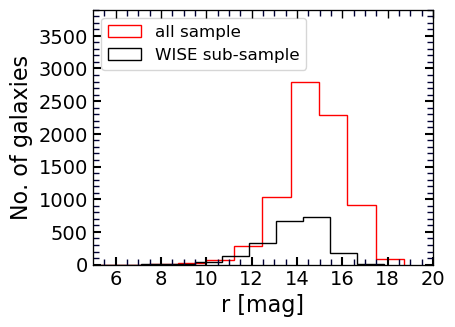

In [28]:
indx, = np.where(np.logical_or(R_source==2,R_source==1))    # W2 is used for reddening correction
r0_sub = table['r'][indx]


fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
                  
ax.hist(r0, bins=15, histtype='step', label='all sample', color='red')
ax.hist(r0_sub, bins=15, histtype='step', label='WISE sub-sample', color='k')

ax.legend(prop={'size': 12}, loc=2)

ax.set_xlabel('r [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)


set_axes([ax], [5,20], [0,3900])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

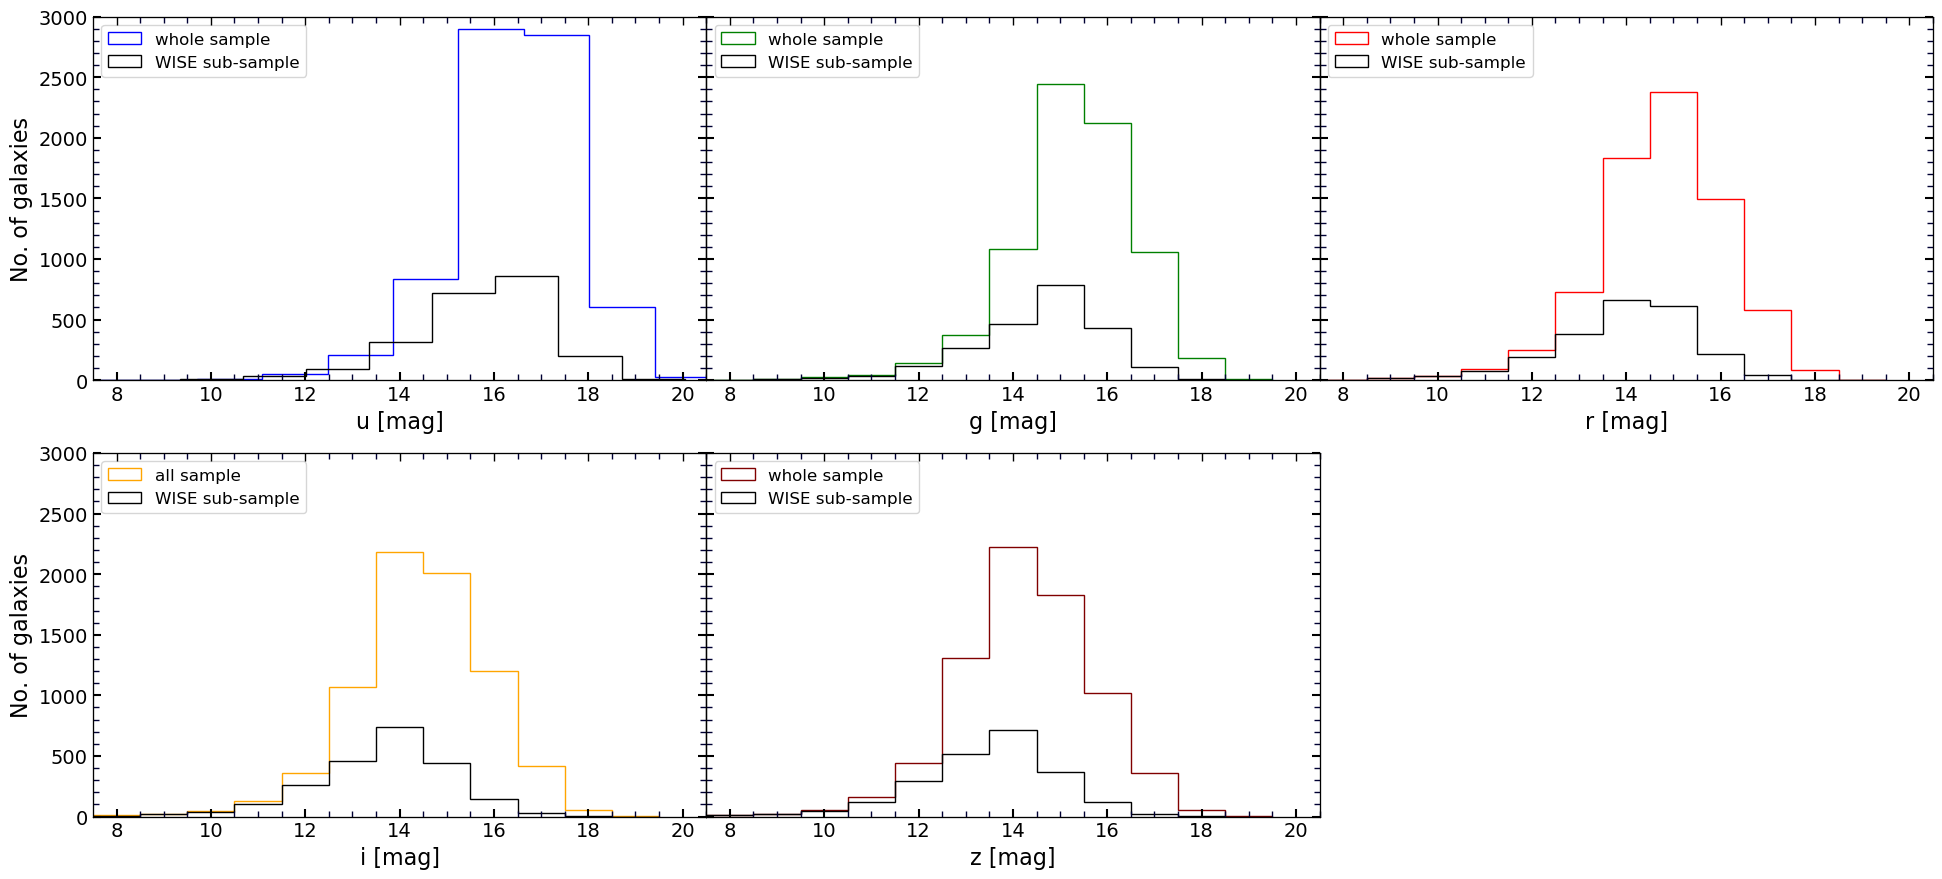

In [29]:
indx, = np.where(i0>5)   # W2 is used for reddening correction
u0_  = table['u'][indx]
g0_  = table['g'][indx]
r0_  = table['r'][indx]
i0_  = table['i'][indx]
z0_  = table['z'][indx]
indx, = np.where(w10>5)   # W2 is used for reddening correction
w10_ = table['w1'][indx]
w20_ = table['w2'][indx]

indx, = np.where(np.logical_and(Wqlt>0, i0>5))   # W2 is used for reddening correction
u0_sub  = table['u'][indx]
g0_sub  = table['g'][indx]
r0_sub  = table['r'][indx]
i0_sub  = table['i'][indx]
z0_sub  = table['z'][indx]


fig = py.figure(figsize=(20, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(2, 3) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])



bins = np.arange(5.5,20.5,1)

ax = ax1
ax.hist(u0_, bins=15, histtype='step', label='whole sample', color='b')
ax.hist(u0_sub, bins=15, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('u [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])


ax = ax2
ax.hist(g0_, bins, histtype='step', label='whole sample', color='g')
ax.hist(g0_sub, bins, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('g [mag]', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])
plt.setp(ax.get_yticklabels(), visible=False)


ax = ax3
ax.hist(r0_, bins, histtype='step', label='whole sample', color='r')
ax.hist(r0_sub, bins, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('r [mag]', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])
plt.setp(ax.get_yticklabels(), visible=False)

ax = ax4
n, bins, patches = ax.hist(i0_, bins, histtype='step', label='all sample', color='orange')
ax.hist(i0_sub, bins, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('i [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])

ax = ax5
ax.hist(z0_, bins, histtype='step', label='whole sample', color='maroon')
ax.hist(z0_sub, bins, histtype='step', label='WISE sub-sample', color='k')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('z [mag]', fontsize=16)
set_axes([ax], [7.5,20.5], [0,3000])
plt.setp(ax.get_yticklabels(), visible=False)



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

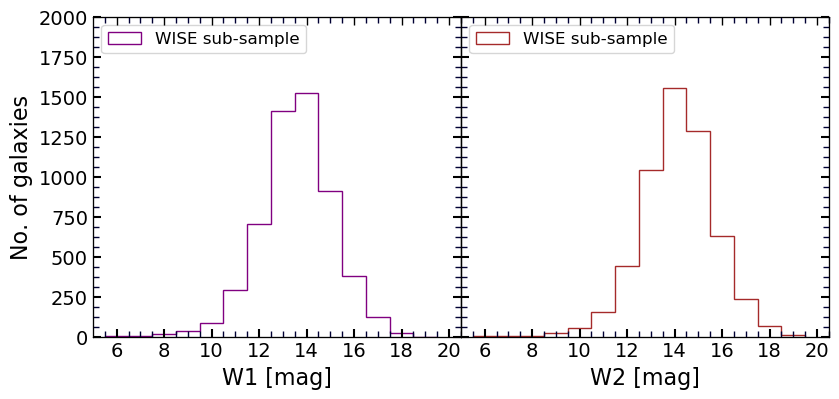

In [30]:
fig = py.figure(figsize=(8, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax = ax1
ax.hist(w10_, bins, histtype='step', label='WISE sub-sample', color='purple')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('W1 [mag]', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)
set_axes([ax], [5,20.5], [0,2000])

ax = ax2
ax.hist(w20_, bins, histtype='step', label='WISE sub-sample', color='brown')
ax.legend(prop={'size': 12}, loc=2)
ax.set_xlabel('W2 [mag]', fontsize=16)
set_axes([ax], [5,20.5], [0,2000])
plt.setp(ax.get_yticklabels(), visible=False)


355
[22446]


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


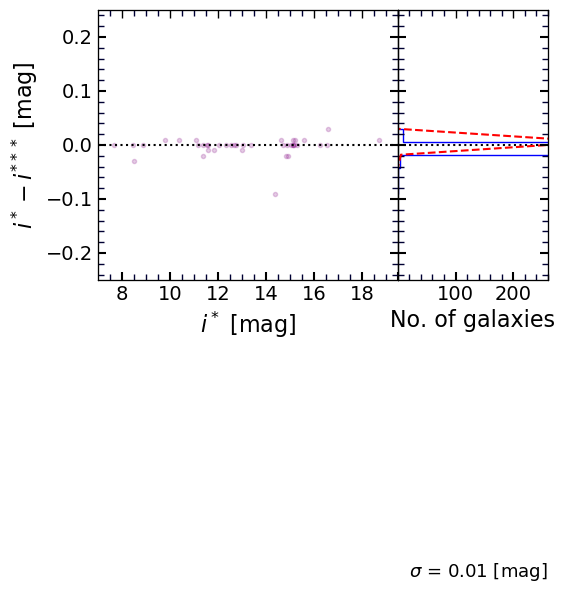

In [31]:
indx, = np.where(R_source==1)    # W2 is used for reddening correction
print len(indx)

iddd = table['pgc'][indx]
W2_lst  = table['i_s'][indx]
w2p_lst = table['i_sss'][indx]

print iddd[np.where(np.abs(W2_lst-w2p_lst)>0.05)]

#################################################################
fig = py.figure(figsize=(6, 3), dpi=100)  
fig.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.20, right=0.95)
gs = gridspec.GridSpec(1,2, width_ratios=[1,0.5]) 

ax = plt.subplot(gs[0])
# ax_ = plt.subplot(gs[1])
ax__ = plt.subplot(gs[1])
#################################################################

ax.plot(W2_lst, W2_lst-w2p_lst, '.', color='purple', alpha=0.2)
ax.plot([-20,20],[0,0], 'k:')
set_axes([ax], [7.,19.5], [-0.25,0.25])
ax.set_xlabel(r'$i^*$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$i^*-i^{***}$'+' [mag]', fontsize=16)


XX = W2_lst-w2p_lst
XX = XX[np.where(np.abs(XX)<1.)]
mu = np.median(XX)
sigma = np.std(XX)
#################################################################
# ax.text(8,-0.75, 'RMS = '+'%.2f'%sigma+' [mag]', fontsize=14, color='k')
ax__.text(20,-0.8, r'$\sigma$'+' = '+'%.2f'%sigma+' [mag]', fontsize=13, color='k')
#################################################################
n, bins, patches = ax__.hist(W2_lst-w2p_lst, bins=5, orientation="horizontal",histtype='step', color='b')
set_axes([ax__], [0,260], [-0.25,0.25])
plt.setp(ax__.get_yticklabels(), visible=False)
ax__.set_xlabel('No. of galaxies', fontsize=16)
import matplotlib.mlab as mlab
ax__.plot([0,1000],[0,0], 'k:')
y = mlab.normpdf(bins, mu, sigma)
d_bin = bins[1]-bins[0]
ax__.plot(1.0*(np.sum(n)*d_bin)*y, bins, 'r--')

a=ax__.get_xticks().tolist()
a[0] = ''
for i in range(1,len(a)):
    a[i]="%d"%a[i]
ax__.set_xticklabels(a)

plt.subplots_adjust(hspace=.0, wspace=0)